In [1]:
import os
import sys
import random
import math
import re
import time
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Root directory of the project
ROOT_DIR = os.path.abspath(os.getcwd())

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import sneaker

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(os.getcwd(), "logdir","train")

# Path to Sneakers trained weights
SNEAKER_WEIGHTS_PATH = "mask_rcnn_sneaker.h5"  # TODO: update this path

Using TensorFlow backend.


In [2]:
config = sneaker.SneakerConfig()
SNEAKER_DIR = os.path.join(ROOT_DIR, "data")

In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [6]:
# Load validation dataset
dataset = sneaker.SneakerDataset()
dataset.load_sneaker(SNEAKER_DIR, "test")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 30
Classes: ['BG', 'sneaker']


In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [8]:
# Set path to sneaker weights file
weights_path = "logdir/train/mask_rcnn_sneaker_0005.h5"
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  logdir/train/mask_rcnn_sneaker_0005.h5


## Test du modèle sur le dataset de test

image ID: sneaker.Sneaker-Test (13).jpeg (12) 
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (2,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (2, 4)                min:   81.00000  max:  955.00000  int32
gt_mask                  shape: (1024, 1024, 2)       min:    0.00000  max:    1.00000  bool


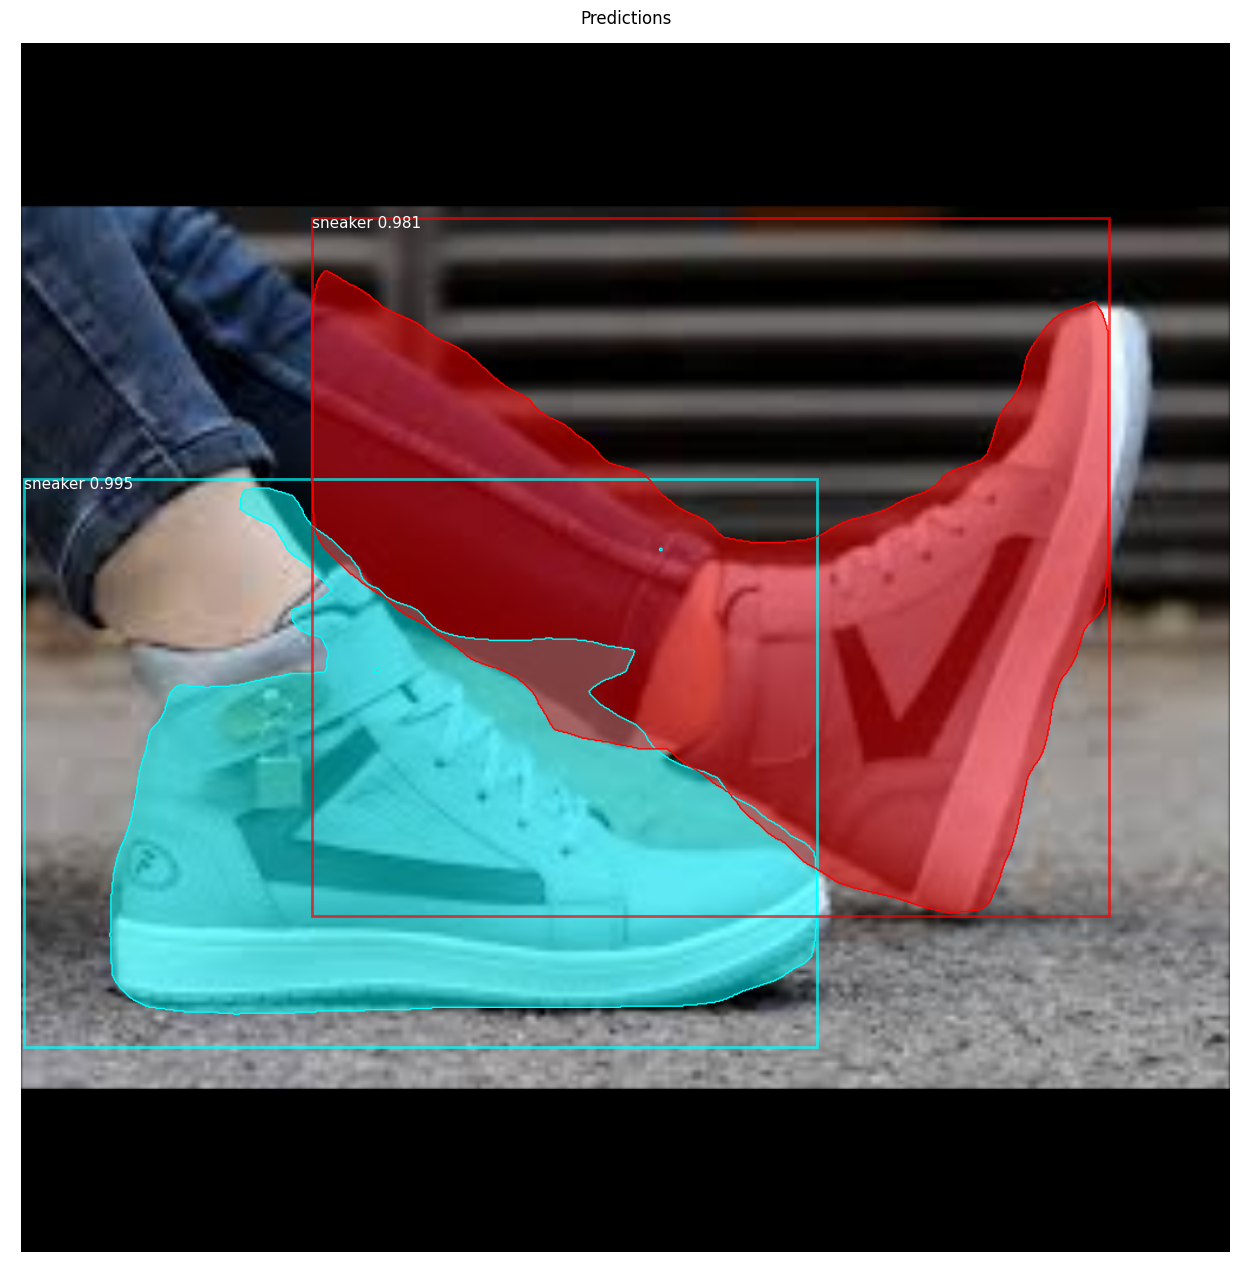

In [9]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

 ## Matrice de confusion

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  4
the actual len of the pred vect is :  4
Average precision of this image
The actual mean average precision for the whole images (matterport methode)  1.0
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actua

the actual len of the gt vect is :  27
the actual len of the pred vect is :  27
Average precision of this image
The actual mean average precision for the whole images (matterport methode)  0.9142857151372092
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  28
the actual len of the pred vect is :  28
Average precision of this image
The actual mean average precision for the whole images (matterport methode)  0.9200000007947285
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000 

E:\M2-LS\IA\sneaker_rcnn-trained\sneaker_rcnn\mrcnn\utils.py:734: RuntimeWarning: invalid value encountered in true_divide
  recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)


the actual len of the gt vect is :  51
the actual len of the pred vect is :  51
Average precision of this image
The actual mean average precision for the whole images (matterport methode)  nan
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


E:\M2-LS\IA\sneaker_rcnn-trained\sneaker_rcnn\mrcnn\utils.py:734: RuntimeWarning: invalid value encountered in true_divide
  recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)


the actual len of the gt vect is :  52
the actual len of the pred vect is :  52
Average precision of this image
The actual mean average precision for the whole images (matterport methode)  nan
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


E:\M2-LS\IA\sneaker_rcnn-trained\sneaker_rcnn\mrcnn\utils.py:734: RuntimeWarning: invalid value encountered in true_divide
  recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)


the actual len of the gt vect is :  53
the actual len of the pred vect is :  53
Average precision of this image
The actual mean average precision for the whole images (matterport methode)  nan
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


E:\M2-LS\IA\sneaker_rcnn-trained\sneaker_rcnn\mrcnn\utils.py:734: RuntimeWarning: invalid value encountered in true_divide
  recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)


the actual len of the gt vect is :  54
the actual len of the pred vect is :  54
Average precision of this image
The actual mean average precision for the whole images (matterport methode)  nan
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  145.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


E:\M2-LS\IA\sneaker_rcnn-trained\sneaker_rcnn\mrcnn\utils.py:734: RuntimeWarning: invalid value encountered in true_divide
  recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)


the actual len of the gt vect is :  60
the actual len of the pred vect is :  60
Average precision of this image
The actual mean average precision for the whole images (matterport methode)  nan


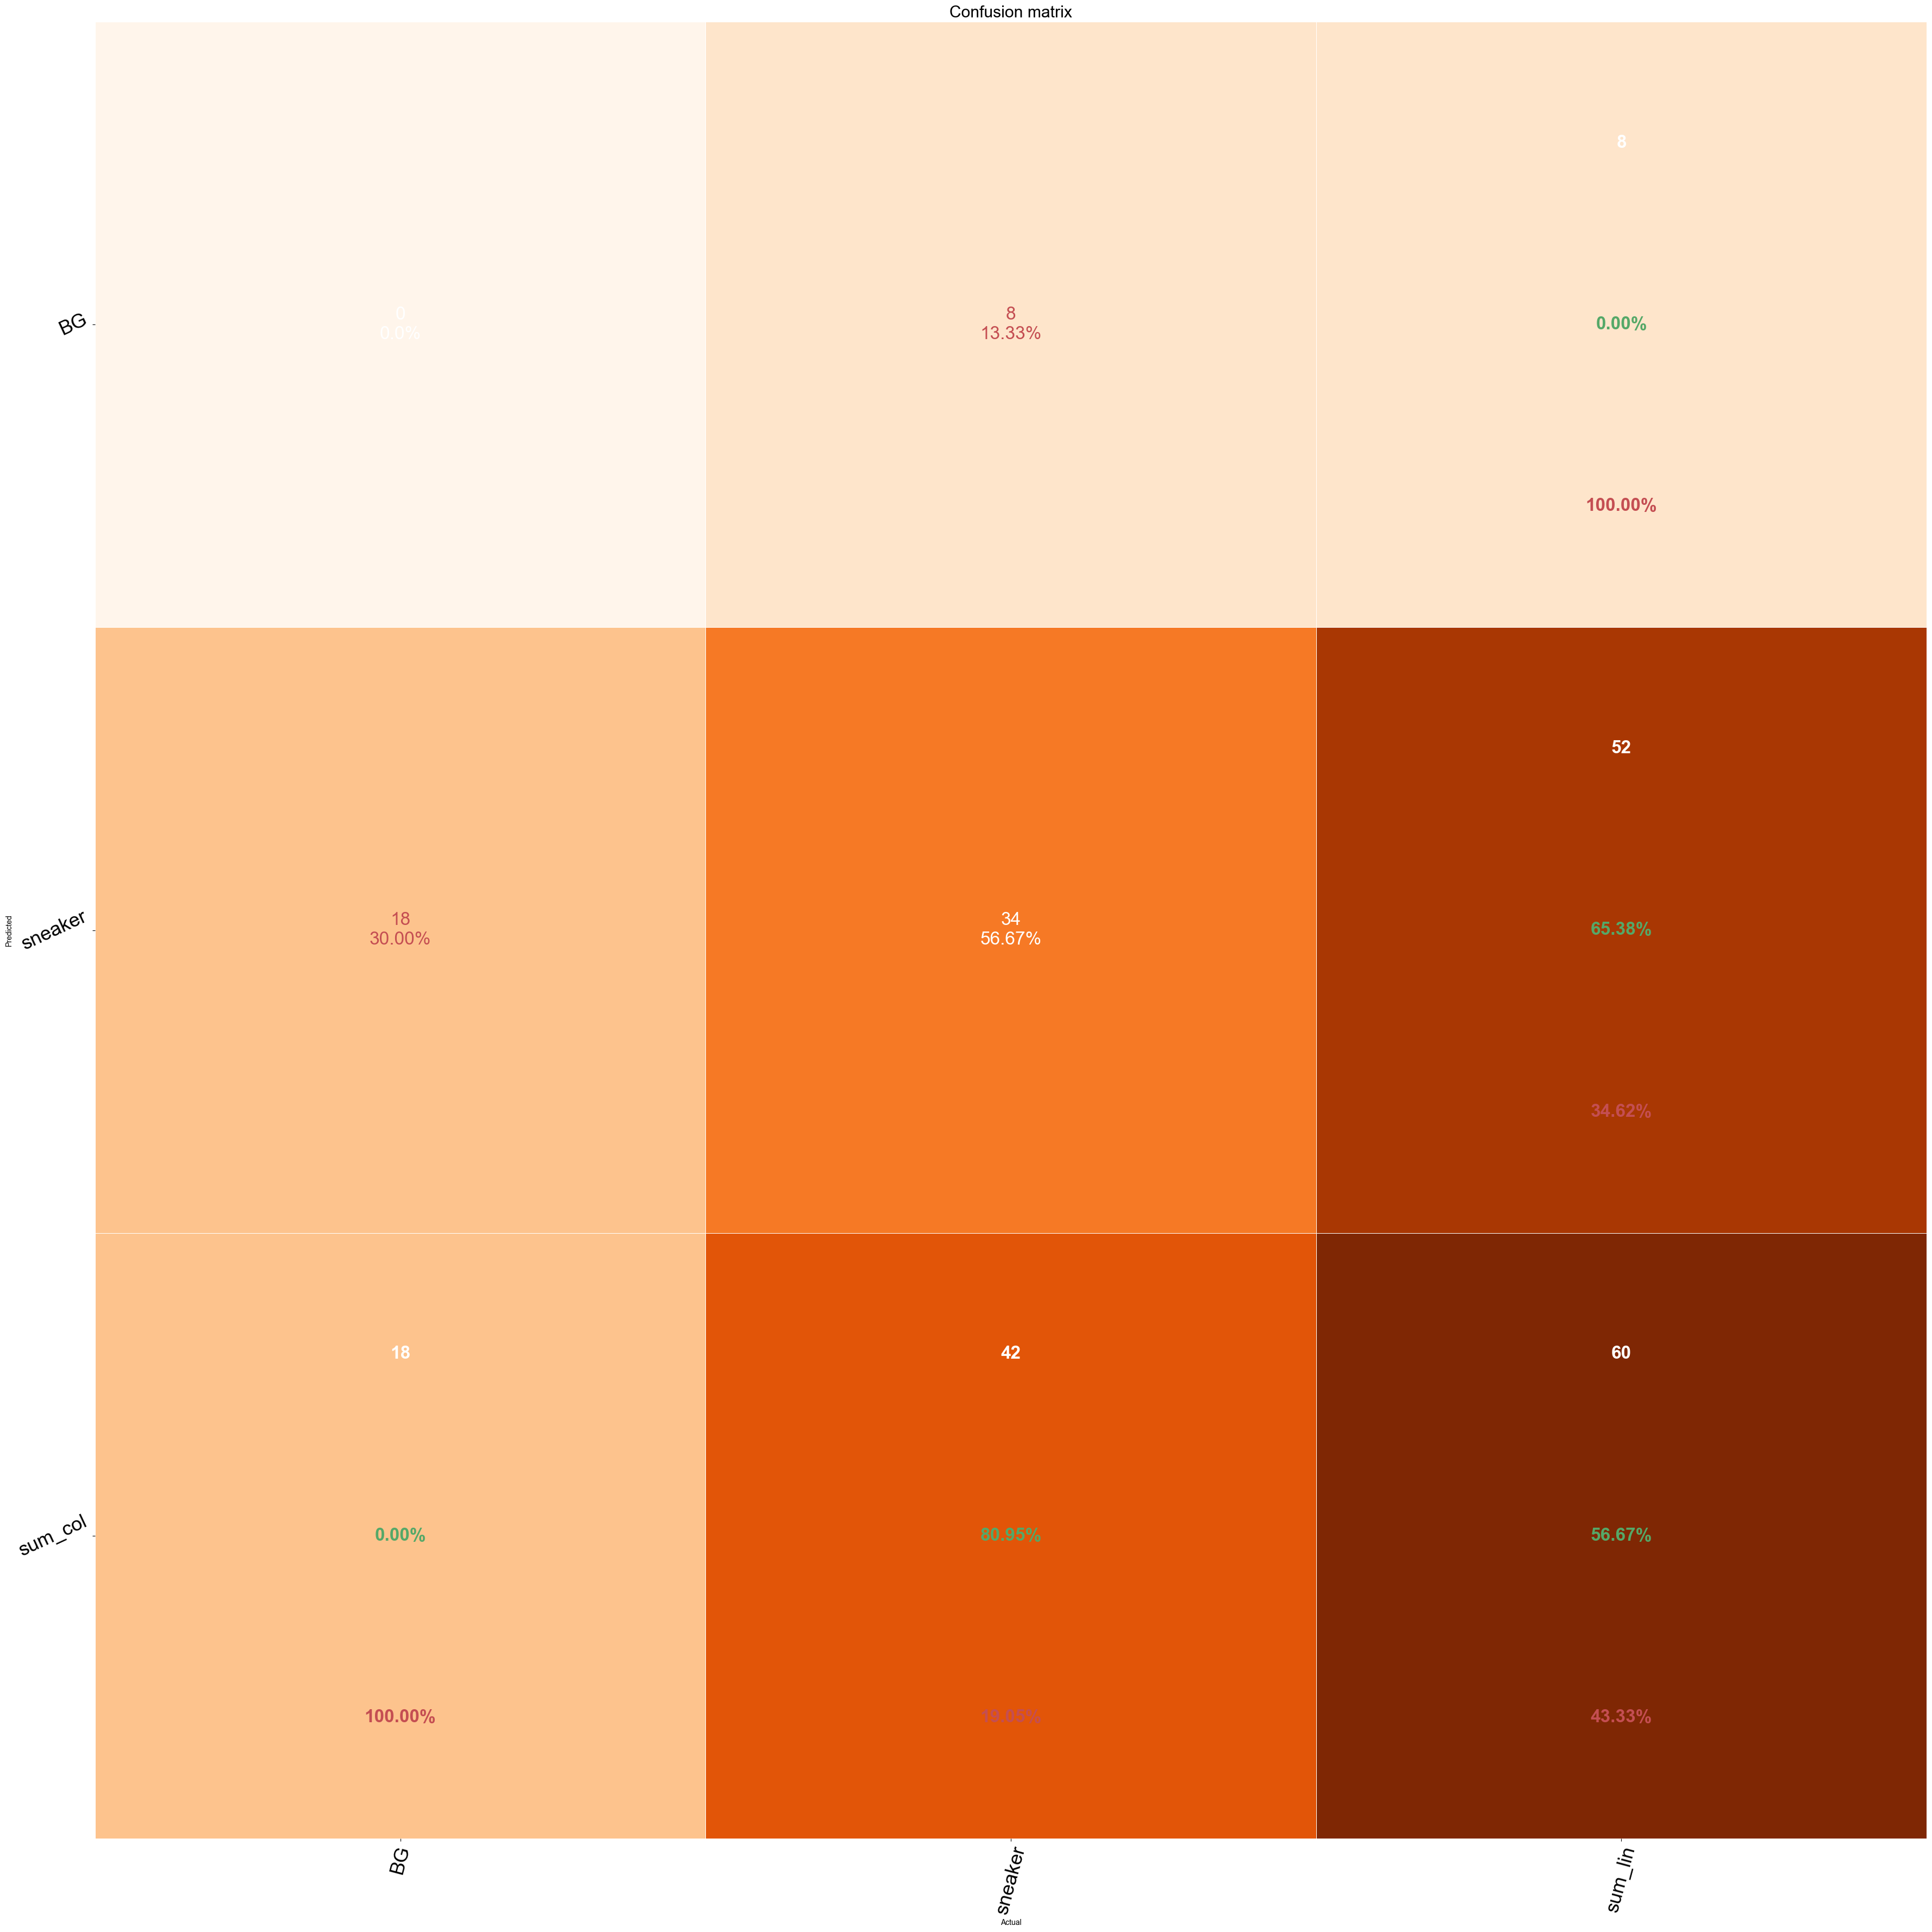

In [10]:
gt_tot = np.array([])
pred_tot = np.array([])
mAP_ = []

for image_id in dataset.image_ids:
#image_id = random.choice(dataset.image_ids)
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    info = dataset.image_info[image_id]
    #print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                           #dataset.image_reference(image_id)))
    # Run object detection
    results = model.detect([image], verbose=1)

    # Display results
    #ax = get_ax(1)
    r = results[0]
    #visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                #dataset.class_names, r['scores'], ax=ax,
                                #title="Predictions")
    gt, pred = utils.gt_pred_lists(gt_class_id, gt_bbox, r['class_ids'], r['rois'])
    gt_tot = np.append(gt_tot, gt)
    pred_tot = np.append(pred_tot, pred)
    #precision_, recall_, AP_ = utils.compute_precision_recall_map(gt_tot, pred_tot)
    AP_, precision_, recall_, overlap_ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
    print("the actual len of the gt vect is : ", len(gt_tot))
    print("the actual len of the pred vect is : ", len(pred_tot))
    mAP_.append(AP_)
    print("Average precision of this image")
    print("The actual mean average precision for the whole images (matterport methode) ", sum(mAP_)/len(mAP_))
    
gt_tot=gt_tot.astype(int)
pred_tot=pred_tot.astype(int)
#save the vectors of gt and pred
save_dir = "ourput"
gt_pred_tot_json = {"gt_tot" : gt_tot, "pred_tot" : pred_tot}
df = pd.DataFrame(gt_pred_tot_json)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
df.to_json(os.path.join(save_dir,"gt_pred_test.json"))

#print the confusion matrix :

tp, fp, fn = utils._test_data_class(dataset.class_names, gt_tot, pred_tot)

## Graphique représentant les pertes d'entrainement et de validation

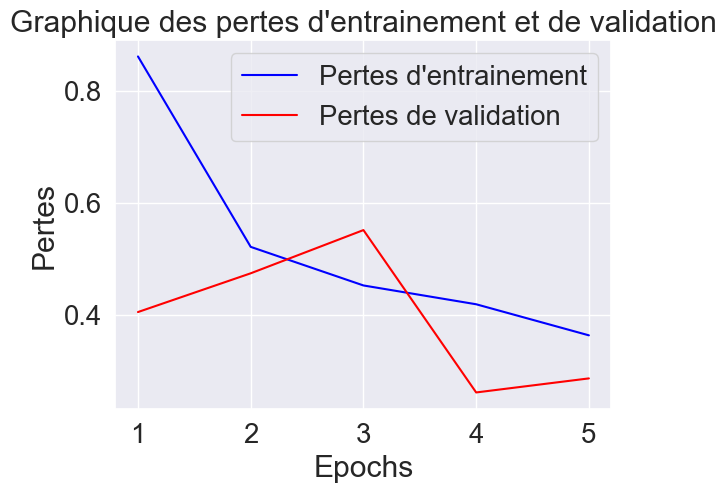

In [12]:
train_losses = [0.8609, 0.5208, 0.4519, 0.4183, 0.3628 ]  # Pertes d'entraînement
val_losses = [0.4044, 0.4736, 0.5508, 0.2608, 0.2859 ]  # Pertes de validation
epochs = [1, 2, 3, 4, 5]  # Numéro des époques

# Tracer les pertes
plt.plot(epochs, train_losses, label='Pertes d\'entrainement', color='blue')
plt.plot(epochs, val_losses, label='Pertes de validation', color='red')

plt.xlabel('Epochs')
plt.ylabel('Pertes')
plt.title('Graphique des pertes d\'entrainement et de validation')
plt.legend()

plt.show()
